# Hospitalization Cleaning

## Imports

In [372]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

## Functions

In [375]:
def count_nulls_in_reception_vs_not_null_release(df):
    count = 0
    for i in range(len(df['Diagnosis_In_Reception'])):
        if (str(df['Diagnosis_In_Reception'][i]) in str(df['Diagnosis_In_Release'][i])):
            count += 1
    print(f'Number of values of \'Diagnosis_In_Reception\' that exist in \'Diagnosis_In_Release\': {count}')
    print(f'Percentage of values contained by \'Diagnosis_In_Release\' column: {round((count/len(df['Diagnosis_In_Reception'])) * 100, 2)}%')

In [377]:
def replace_na_vals_in_reception_diagnosis(df):
    for i in range(len(df['Diagnosis_In_Reception'])):
        if (df['Diagnosis_In_Reception'][i] == -1 and df['Diagnosis_In_Release'][i] != -2):
            df.loc[i, 'Diagnosis_In_Reception'] = df['Diagnosis_In_Release'][i]
    print(f'Number of missing values left in \'Diagnosis_In_Reception\' column: {df['Diagnosis_In_Reception'].value_counts()[-1]}')

In [379]:
def replace_missing_values_diagnosis_in_release(df):
    for i in range(len(df['Diagnosis_In_Release'])):
        if (df['Diagnosis_In_Reception'][i] != -1 and df['Diagnosis_In_Release'][i] == -2):
            df.loc[i, 'Diagnosis_In_Release'] = df['Diagnosis_In_Reception'][i]
        elif (df['Diagnosis_In_Reception'][i] == -1 and df['Diagnosis_In_Release'][i] == -2):
            df.loc[i, 'Diagnosis_In_Release'] = -1
    print(f'Number of missing values left in \'Diagnosis_In_Release\' column: {df['Diagnosis_In_Release'].value_counts()[-1]}')

In [381]:
def count_missing_doctors_with_no_diagnosis(df):
    count = 0
    for i in range(len(df['Releasing_Doctor'])):
        if (df['Diagnosis_In_Reception'][i] == -1 and df['Diagnosis_In_Release'][i] == -1 and df['Releasing_Doctor'][i] == -1):
            count += 1
    print(f'Number of releasing doctors with no diagnosis: {count}')

In [383]:
def add_diagnosis_to_cats(cats, diag):
    if ',' in diag:
        split_diag = diag.split(',')
        for value in split_diag:
            value = value.strip()
            if (value not in cats and value != ''):
                cats.append(value)
    elif diag.strip() not in cats and diag.strip() != '':
        cats.append(diag.strip())

In [385]:
def get_diag_categories_for_missing_doctors(df):
    cats = []
    for i in range(len(df['Releasing_Doctor'])):
        if (df['Releasing_Doctor'][i] == -1):
            if (df['Diagnosis_In_Release'][i] != -1):
                diag = str(df['Diagnosis_In_Release'][i])
                add_diagnosis_to_cats(cats, diag)
            elif (df['Diagnosis_In_Reception'][i] != -1):
                diag = str(df['Diagnosis_In_Reception'][i])
                add_diagnosis_to_cats(cats, diag)
    return cats

In [387]:
def create_doc_to_cat_dict(df, cats):
    doc_to_cats_dict = {}
    cats_dict = dict(zip(cats, [0] * len(cats)))
    for doc in df['Releasing_Doctor'].unique():
        doc_to_cats_dict[doc] = cats_dict.copy()
    return doc_to_cats_dict

In [389]:
def add_value_to_doc_cat_dict(diag, doc, cats, doc_to_cat_dict):
    if ',' in diag:
        split_diag = diag.split(',')
        for value in split_diag:
            value = value.strip()
            if (value in cats and value != ''):
                doc_to_cat_dict[doc][value] += 1
    elif (diag.strip() in cats and diag.strip() != ''):
        doc_to_cat_dict[doc][diag.strip()] += 1

In [391]:
def get_doctor_counts_dict_for_each_category(df, cats):
    doc_to_cat_dict = create_doc_to_cat_dict(df, cats)
    for i in range(len(df['Releasing_Doctor'])):
        doc = df['Releasing_Doctor'][i]
        if (df['Diagnosis_In_Release'][i] != -1):
            diag = str(df['Diagnosis_In_Release'][i])
            add_value_to_doc_cat_dict(diag, doc, cats, doc_to_cat_dict)
        elif (df['Diagnosis_In_Reception'][i] != -1):
            diag = str(df['Diagnosis_In_Reception'][i])
            add_value_to_doc_cat_dict(diag, doc, cats, doc_to_cat_dict)
    return doc_to_cat_dict

In [393]:
def get_doc_with_most_diag_cases_dict(doc_to_diag_dict, cats, df):
    most_diag_to_doc_dict = {}
    for cat in cats:
        most_diag_to_doc_dict[cat] = {}
        best_doc = ''
        max_val = -1
        for doc in df['Releasing_Doctor'].unique():
            if (doc_to_diag_dict[doc][cat] > max_val and doc != -1):
                best_doc = doc
                max_val = doc_to_diag_dict[doc][cat]
        most_diag_to_doc_dict[cat][best_doc] = max_val
    return most_diag_to_doc_dict

In [395]:
def get_diag(diag):
    if ',' in diag:
        split_diag = diag.split(',')
        for value in split_diag:
            value = value.strip()
            if value != '':
                return value
    elif diag.strip() != '':
        return diag.strip()

In [397]:
def fill_releasing_doctor(df, cat_doc_most):
    for i in range(len(df['Releasing_Doctor'])):
        if df['Releasing_Doctor'][i] == -1:
            if df['Diagnosis_In_Release'][i] != -1:
                diag = get_diag(str(df['Diagnosis_In_Release'][i]))
                df.loc[i, 'Releasing_Doctor'] = list(cat_doc_most[diag].keys())[0]
            elif df['Diagnosis_In_Reception'][i] != -1:
                diag = get_diag(str(df['Diagnosis_In_Reception'][i]))
                df.loc[i, 'Releasing_Doctor'] = list(cat_doc_most[diag].keys())[0]

In [399]:
def translate_column(df, translations_dict, column_name):
    for i in range(len(df[column_name])):
        df.loc[i, column_name] = translations_dict[df[column_name][i]]

In [401]:
def remove_comma(df):
    for i in range (len(df['Diagnosis_In_Release'])):
        if df['Diagnosis_In_Release'][i] != -1:
            diag = str(df['Diagnosis_In_Release'][i])
            if diag.strip().startswith(','):
                diag = diag.strip()[1:]
            if diag.strip().endswith(','):
                diag = diag.strip()[0:len(diag.strip()) - 1]
            df.loc[i, 'Diagnosis_In_Release'] = diag
        if df['Diagnosis_In_Reception'][i] != -1:
            diag = str(df['Diagnosis_In_Reception'][i])
            if diag.strip().startswith(','):
                diag = diag.strip()[1:]
            if diag.strip().endswith(','):
                diag = diag.strip()[0:len(diag.strip()) - 1]
            df.loc[i, 'Diagnosis_In_Reception'] = diag

## Load Dataset

First we load the Excel file into a pandas DataFrame

In [405]:
df = pd.read_excel('hospitalization2.xlsx')

Translate column names from hebrew to english

In [407]:
df_copy = df
df_copy.rename(columns={'סוג קבלה': 'Entry_Type'}, inplace=True)
df_copy.rename(columns={'מהיכן המטופל הגיע': 'Patient_Origin'}, inplace=True)
df_copy.rename(columns={'רופא משחרר': 'Releasing_Doctor'}, inplace=True)
df_copy.rename(columns={'ימי אשפוז': 'Admission_Days2'}, inplace=True)
df_copy.rename(columns={'אבחנות בקבלה': 'Diagnosis_In_Reception'}, inplace=True)
df_copy.rename(columns={'אבחנות בשחרור': 'Diagnosis_In_Release'}, inplace=True)
df_copy.rename(columns={'מחלקות מייעצות': 'Advisory_Departments'}, inplace=True)

First we check the info regarding each column in the Dataframe.

In [409]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8917 entries, 0 to 8916
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Patient                    8917 non-null   int64         
 1   unitName1                  8917 non-null   int64         
 2   Admission_Medical_Record   8917 non-null   int64         
 3   Admission_Entry_Date       8917 non-null   datetime64[ns]
 4   Release_Date               8917 non-null   datetime64[ns]
 5   unitName2                  8917 non-null   int64         
 6   Admission_Medical_Record2  8917 non-null   int64         
 7   Admission_Entry_Date2      8917 non-null   datetime64[ns]
 8   Release_Date2              8917 non-null   datetime64[ns]
 9   Entry_Type                 8849 non-null   object        
 10  Patient_Origin             8917 non-null   object        
 11  Release_Type               8917 non-null   object        
 12  Releas

## Data Completion

We now check if there are null values and if so, how many are there and in which column.

In [412]:
np.sum(df_copy.isnull(), axis = 0)

Patient                         0
unitName1                       0
Admission_Medical_Record        0
Admission_Entry_Date            0
Release_Date                    0
unitName2                       0
Admission_Medical_Record2       0
Admission_Entry_Date2           0
Release_Date2                   0
Entry_Type                     68
Patient_Origin                  0
Release_Type                    0
Releasing_Doctor               88
Admission_Days2                 0
Diagnosis_In_Reception        802
Diagnosis_In_Release          233
Advisory_Departments         4176
ct                              0
dtype: int64

We can see that we have 802 missing values in the Diagnoses_in_reception, 233 missing values in Diagnoses_in_release and 88 missing in Releasing_doctor.

We know that in the ICD9 file where we have a mapping of a Diagnosis to an ID, we also have NULL IDs for some values. We assume that the NULL values are from rows where the Diagnosis does not have an ID.

We can see that the diagnosis in reception has more null values than the diagnosis in release. We will first check how many values of diagnosis in release are containing the diagnosis in reception. To do this, we will first set the null values in diagnosis in reception to be -1 and the null values of diagnosis in release to be -2 so we can handle the count better.

In [414]:
df_copy.fillna({'Diagnosis_In_Reception': -1}, inplace=True)
df_copy.fillna({'Diagnosis_In_Release': -2}, inplace=True)
np.sum(df_copy.isnull(), axis = 0)

Patient                         0
unitName1                       0
Admission_Medical_Record        0
Admission_Entry_Date            0
Release_Date                    0
unitName2                       0
Admission_Medical_Record2       0
Admission_Entry_Date2           0
Release_Date2                   0
Entry_Type                     68
Patient_Origin                  0
Release_Type                    0
Releasing_Doctor               88
Admission_Days2                 0
Diagnosis_In_Reception          0
Diagnosis_In_Release            0
Advisory_Departments         4176
ct                              0
dtype: int64

We can now see that the null values in both 'diagnosis in reception' and 'diagnosis in release' columns are not showing as they were set a value of -1 and -2 respectively.

We will now count the values as explained before. We do this to see if most of the values in 'diagnosis in release' also exist in the 'diagnosis in release columns'. If so, then we will just fill the null values in 'diagnosis in reception' with the values of 'diagnosis in release' so we can check later if it has an effect on the performance of the model. We will perform the check with this approach and compare it to a model where the null values were just set to -1 for 'UNKNOWN',

In [416]:
count_nulls_in_reception_vs_not_null_release(df_copy)

Number of values of 'Diagnosis_In_Reception' that exist in 'Diagnosis_In_Release': 6323
Percentage of values contained by 'Diagnosis_In_Release' column: 70.91%


We can see that the 'Diagnosis_in_release' column holds almost 71% of the data that exists in the 'Diagnosis_in_reception' column. 
We will now fill the missing values of 'Diagnosis_in_reception' with the values that exist in 'Diagnosis_in_release' (unless they are -2, marking that this is also a null value).

In [418]:
replace_na_vals_in_reception_diagnosis(df_copy)
count_nulls_in_reception_vs_not_null_release(df_copy)

Number of missing values left in 'Diagnosis_In_Reception' column: 221
Number of values of 'Diagnosis_In_Reception' that exist in 'Diagnosis_In_Release': 6904
Percentage of values contained by 'Diagnosis_In_Release' column: 77.43%


We can see that we still have 221 missing values in the 'Diagnosis_in_reception' column. This means that we have 221 values that are -1 in the 'Diagnosis_in_reception' column and -2 in the 'Diagnosis_in_release' column (both columns are containing null values). 

Since we started with 233 missing values in the 'Diagnosis_in_release' column, we know we still have some values that are missing but exist in the 'Diagnosis_in_reception' column. We will fill these values and continue set the other other values to -1 to remain consistent with the 'UNKNONW' value.

In [426]:
replace_missing_values_diagnosis_in_release(df_copy)

Number of missing values left in 'Diagnosis_In_Release' column: 221


We can see now that we have 221 missing values in both columns of 'Diagnosis_in_reception' and 'Diagnosis_in_release'.
We will leave it like this for now.

We will now continue to complete the data focusing first on the 'Releasing_doctor' column.
We will fill the missing values for the 'Releasing_dotor' with -1 as and check if there are any columns with no diagnosis for these rows. 

In [429]:
df_copy.fillna({'Releasing_Doctor': -1} , inplace=True)
np.sum(df_copy.isnull(), axis = 0)

Patient                         0
unitName1                       0
Admission_Medical_Record        0
Admission_Entry_Date            0
Release_Date                    0
unitName2                       0
Admission_Medical_Record2       0
Admission_Entry_Date2           0
Release_Date2                   0
Entry_Type                     68
Patient_Origin                  0
Release_Type                    0
Releasing_Doctor                0
Admission_Days2                 0
Diagnosis_In_Reception          0
Diagnosis_In_Release            0
Advisory_Departments         4176
ct                              0
dtype: int64

In [432]:
count_missing_doctors_with_no_diagnosis(df_copy)

Number of releasing doctors with no diagnosis: 2


We can see that we have only 2 missing releasing doctors that have no diagnosis at all. We will decide what to do with them later. 

We will now check what are the observations that each exist in these columns so we can check whichc doctor had the most cases with this obesrvation and fill in the missing doctor value.

In [435]:
diag_categories = get_diag_categories_for_missing_doctors(df_copy)
len(diag_categories)

91

In [437]:
df_copy['Releasing_Doctor'] = df_copy['Releasing_Doctor'].astype(int)
len(df_copy['Releasing_Doctor'].unique()) - 1

214

We can see that we have 91 diagnosis categories and 214 total releasing doctors. We will now check to see for each category which doctor had the most cases. We will then fill the missing doctor value with that specific doctor.

In [440]:
doc_to_cat_dict = get_doctor_counts_dict_for_each_category(df_copy, diag_categories)

In [442]:
cat_doc_most = get_doc_with_most_diag_cases_dict(doc_to_cat_dict, diag_categories, df_copy)
cat_doc_most

{'7807': {6888: 9},
 '5130': {10923: 1},
 '2761': {12639: 7},
 '5950': {11023: 0},
 '7907': {10760: 10},
 '43491': {6888: 5},
 '5849': {6888: 20},
 '99591': {11023: 8},
 '2767': {6888: 8},
 '5990': {1052: 9},
 '42833': {10806: 2},
 'O8889': {12587: 24},
 '079.84': {11360: 7},
 '4340': {12354: 1},
 'Z3822': {11023: 0},
 '7895': {12587: 18},
 '34290': {11673: 1},
 '79091': {12886: 3},
 '6829': {8826: 3},
 '1970': {12599: 2},
 '79902': {9971: 1},
 '03843': {1052: 1},
 '2859': {6888: 19},
 '78060': {6888: 29},
 '7862': {11233: 3},
 '4110': {11023: 0},
 '5119': {6888: 24},
 '0389': {12354: 5},
 '584': {11023: 9},
 '5070': {10313: 12},
 '389': {12649: 3},
 '41071': {11023: 4},
 '4241': {10760: 4},
 '7865': {11670: 11},
 '413': {9281: 3},
 '7824': {10112: 2},
 '70723': {11842: 2},
 '7804': {11023: 3},
 '4415': {11023: 0},
 '514': {10760: 11},
 '7070': {11515: 3},
 '70724': {11848: 2},
 '7150': {10280: 2},
 '27651': {10112: 7},
 'INT1': {10760: 13},
 '5789': {11670: 7},
 '70722': {6878: 2},
 '

In [444]:
fill_releasing_doctor(df_copy, cat_doc_most)

In [446]:
df_copy['Releasing_Doctor'].value_counts()[-1]

2

We can see that we remain with only two rows not containing 'Diagnosis_in_reception', 'Diagnosis_in_release' and 'Releasing_doctor'. 

We will drop these two rows later as these features are highly relevant to the research question and since it is only two rows, we can assume it will not have a big effect on the model's performance.

For the entry type, we will check which type is the most common and fill the null values with that type.

In [450]:
df_copy['Entry_Type'].value_counts()

Entry_Type
דחוף         7940
מוזמן         890
אשפוז יום      19
Name: count, dtype: int64

We can see that the most common type is 'urgent' with 7940 rows. We will fill the empty values in this column with 'urgent' value.

In [453]:
df_copy.fillna({'Entry_Type': 'דחוף'}, inplace=True)
np.sum(df_copy.isnull(), axis = 0)

Patient                         0
unitName1                       0
Admission_Medical_Record        0
Admission_Entry_Date            0
Release_Date                    0
unitName2                       0
Admission_Medical_Record2       0
Admission_Entry_Date2           0
Release_Date2                   0
Entry_Type                      0
Patient_Origin                  0
Release_Type                    0
Releasing_Doctor                0
Admission_Days2                 0
Diagnosis_In_Reception          0
Diagnosis_In_Release            0
Advisory_Departments         4176
ct                              0
dtype: int64

In [455]:
df_copy['Entry_Type'].value_counts()

Entry_Type
דחוף         8008
מוזמן         890
אשפוז יום      19
Name: count, dtype: int64

We can see that the null values were indeed filled with the 'urgent' value.

We will translate the data from hebrew to english.

In [458]:
translation_dict = {'דחוף': 'urgent', 'מוזמן' : 'scheduled', 'אשפוז יום' : 'day hospitalization'}
translate_column(df_copy, translation_dict, 'Entry_Type')

In [459]:
translation_dict = {'ממרפאה': 'medical clinic', 'מבית חולים אחר' : 'different hospital', 'ממוסד' : 'institude', 'מביתו' : 'home', 'אחר' : 'other'}
translate_column(df_copy, translation_dict, 'Patient_Origin')

In [460]:
translation_dict = {'שוחרר לביתו': 'home', 'שוחרר למוסד' : 'institude'}
translate_column(df_copy, translation_dict, 'Release_Type')

Drop Advisory_departments column as it is not relevant for the research question and too many null values.

In [462]:
df_copy = df_copy.drop(columns=['Advisory_Departments'])
np.sum(df_copy.isnull(), axis = 0)

Patient                      0
unitName1                    0
Admission_Medical_Record     0
Admission_Entry_Date         0
Release_Date                 0
unitName2                    0
Admission_Medical_Record2    0
Admission_Entry_Date2        0
Release_Date2                0
Entry_Type                   0
Patient_Origin               0
Release_Type                 0
Releasing_Doctor             0
Admission_Days2              0
Diagnosis_In_Reception       0
Diagnosis_In_Release         0
ct                           0
dtype: int64

Convert columns to datetime format

In [464]:
df_copy['Admission_Entry_Date'] = pd.to_datetime(df_copy['Admission_Entry_Date'], format='%d/%m/%Y %H:%M')
df_copy['Release_Date'] = pd.to_datetime(df_copy['Release_Date'], format='%d/%m/%Y %H:%M:%S')

Calculate duration in days, rounded

In [467]:
df_copy['Admission_Days'] = (df_copy['Release_Date'] - df_copy['Admission_Entry_Date']).dt.round('D').abs().dt.days

Create an array that counts the occurrences of each duration

In [469]:
duration_counts = df_copy['Admission_Days'].value_counts().sort_index()

We will now remove ',' at the start and end of the diagnosis columns.

In [472]:
remove_comma(df_copy)

We will now drop the remaining rows that have no data to work with as a part of the cleaning process that was done.

In [474]:
rows_to_drop = df_copy.index[(df_copy['Releasing_Doctor'] == -1) & (df_copy['Diagnosis_In_Reception'] == -1) & (df_copy['Diagnosis_In_Release'] == -1)].tolist()
rows_to_drop

[254, 6118]

We will add anothe column named 'Days_Between_Admissions' that will be the target variable.

In [483]:
df_copy['Admission_Entry_Date2'] = pd.to_datetime(df_copy['Admission_Entry_Date2'], format='%d/%m/%Y %H:%M')
df_copy['Days_Between_Admissions'] = (df_copy['Admission_Entry_Date2'] - df_copy['Release_Date']).dt.round('D').abs().dt.days

In [485]:
df_copy['Days_Between_Admissions']

0        5
1       24
2        1
3       27
4        7
        ..
8912    19
8913    17
8914    14
8915    29
8916    19
Name: Days_Between_Admissions, Length: 8917, dtype: int64

In [487]:
df_copy['Days_Between_Admissions'].value_counts()

Days_Between_Admissions
1     492
3     491
2     469
4     452
6     429
7     410
5     382
12    339
14    336
11    321
9     315
13    311
8     304
10    283
15    259
19    255
17    251
20    248
21    245
18    238
16    238
22    229
28    227
25    209
29    203
27    201
24    197
23    191
26    172
0     143
30     77
Name: count, dtype: int64

We will now find the optimal split for the 3 groups that will be the target categories: 'short', 'mid', 'long'.

We will first create an array that counts the occurrences of each duration and the plot the results to a histogram.

In [490]:
duration_counts = df_copy['Days_Between_Admissions'].value_counts().sort_index()

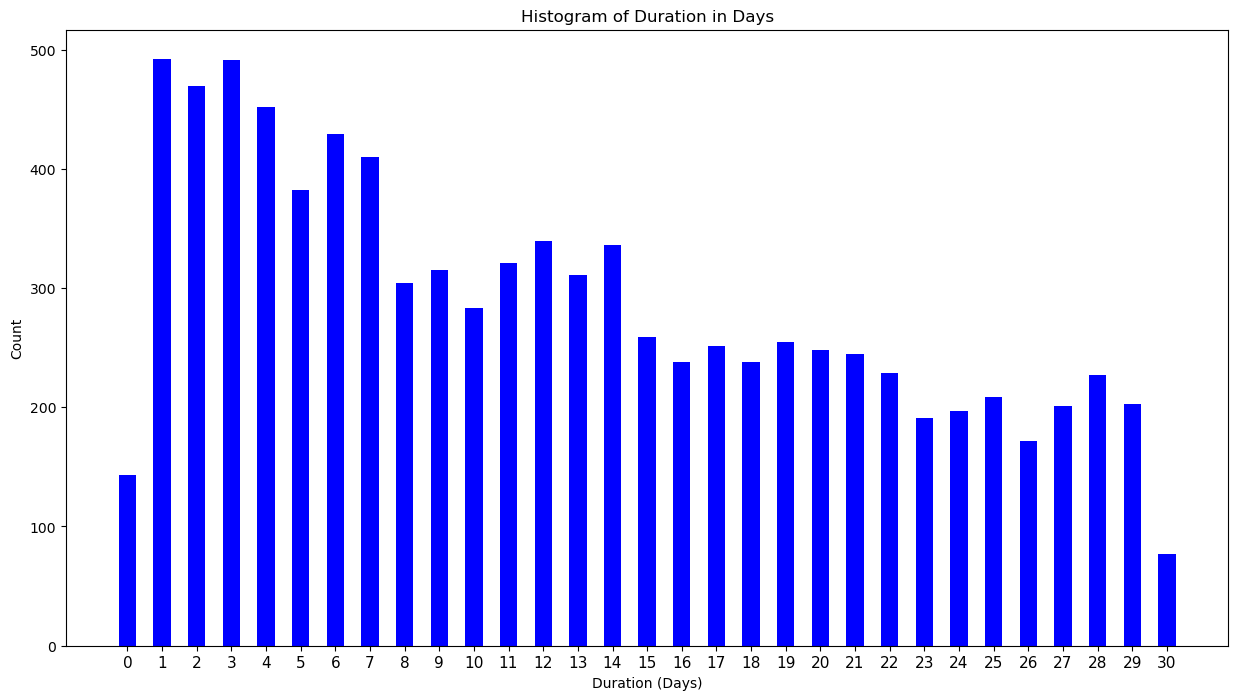

In [492]:
# Plot the histogram
plt.figure(figsize=(15, 8))
plt.bar(duration_counts.index, duration_counts.values, width=0.5, color='blue')
plt.xlabel('Duration (Days)')
plt.ylabel('Count')
plt.title('Histogram of Duration in Days')
plt.xticks(duration_counts.index)  # Ensure each duration day is a tick
plt.xticks(fontsize=11)
plt.show()

We can see that there is a down slope trend in the histogram, meaning that the more days pass, less people return to second hospitalization.

We will now find the optimal split for this data according to quartiles into 3 groups. Each group will later be encoded into the desired target variable.

In [495]:
quartiles = np.percentile(df_copy['Days_Between_Admissions'], [33, 67])

In [497]:
bin_edges = [df_copy['Days_Between_Admissions'].min(), quartiles[0], quartiles[1], df_copy['Admission_Days'].max()]

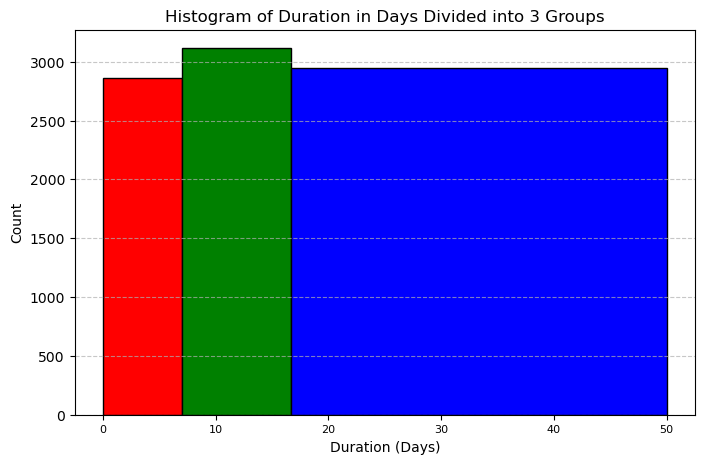

In [499]:
# Define colors for the four quartile bins
colors = ['red', 'green', 'blue']  # One color for each quartile

# Plot histogram using the defined bin edges and assign different colors for each quartile
plt.figure(figsize=(8, 5))
n, bins, patches = plt.hist(df_copy['Days_Between_Admissions'], bins=bin_edges, edgecolor='black')

# Assign different colors to the patches (bars)
for i, patch in enumerate(patches):
    patch.set_facecolor(colors[i % len(colors)])  # Assign color from the list

# Add labels and titles
plt.xlabel('Duration (Days)')
plt.ylabel('Count')
plt.title('Histogram of Duration in Days Divided into 3 Groups')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=8)

plt.show()

In [501]:
# Create labels for the groups based on bin edges
bin_labels = [
    f"Group 1: {int(bin_edges[0])} - {int(bin_edges[1])}",
    f"Group 2: {int(bin_edges[1])} - {int(bin_edges[2])}",
    f"Group 3: {int(bin_edges[2])} - {int(bin_edges[3])}",
]

In [503]:
# Print the group ranges
print("Groups Distribution:\n")
for label in bin_labels:
    print(f"{label} days in admission2\n")

Groups Distribution:

Group 1: 0 - 7 days in admission2

Group 2: 7 - 16 days in admission2

Group 3: 16 - 50 days in admission2



We can see that the optimal split for the groups will be set as the following: Group 1 - 'short' (0-7 Days), Group 2 - 'mid' (7-16 Days), Group 3 - 'long' (16-50 Days). These values will now be encoded into a new column called 'Period_Between_Admissions'.


In [506]:
df_copy['Period_Between_Admissions'] = 'long'
df_copy.loc[df_copy['Days_Between_Admissions'] < bin_edges[1], 'Period_Between_Admissions'] = 'short'
df_copy.loc[(df_copy['Days_Between_Admissions'] >= bin_edges[1]) & (df_copy['Days_Between_Admissions'] < bin_edges[2]), 'Period_Between_Admissions'] = 'mid'
df_copy.loc[df_copy['Days_Between_Admissions'] >= bin_edges[2], 'Period_Between_Admissions'] = 'long'

We will now drop the irrelevant columns for the research question.

In [509]:
df_copy.drop(columns=['Patient', 'Admission_Medical_Record', 'Admission_Medical_Record2', 'Days_Between_Admissions'], inplace=True)

In [511]:
df_copy.drop(rows_to_drop, inplace=True)

In [513]:
df_copy

,unitName1,Admission_Entry_Date,Release_Date,unitName2,Admission_Entry_Date2,Release_Date2,Entry_Type,Patient_Origin,Release_Type,Releasing_Doctor,Admission_Days2,Diagnosis_In_Reception,Diagnosis_In_Release,ct,Admission_Days,Period_Between_Admissions
0,5,2021-02-16 17:33:45.570,2021-02-19 12:40:00,5,2021-02-24 15:03:30.490,2021-02-25 12:38:00,urgent,home,home,11023,1,"5370 , 7872 , 78720","5370 , 7872 , 78720",0,3,short
1,4,2022-08-07 13:27:58.780,2022-08-08 15:15:00,4,2022-09-01 04:20:51.617,2022-09-02 16:00:00,urgent,home,home,12517,1,78060,78060,0,1,long
2,5,2023-10-27 07:34:41.013,2023-10-29 17:18:00,5,2023-10-30 17:58:09.730,2023-11-01 15:33:00,urgent,home,home,11887,2,5119,"5119 , 514",0,2,short
3,3,2020-07-29 17:00:56.863,2020-08-03 14:26:00,3,2020-08-30 04:25:30.670,2020-09-03 13:45:00,urgent,home,home,10525,4,"2859 , 7807","486 , 5990",0,5,long
4,1,2021-07-03 11:42:24.973,2021-07-05 17:34:00,1,2021-07-13 01:21:32.077,2021-07-15 11:48:00,urgent,home,home,6890,2,7865,7865,1,2,mid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8912,3,2022-07-20 15:04:21.510,2022-07-24 14:30:00,3,2022-08-12 11:46:11.473,2022-08-15 15:21:00,urgent,home,institude,10126,3,2501,"0389 , 2501 , INT1",1,4,long
8913,1,2023-07-22 19:36:52.480,2023-07-23 16:06:00,1,2023-08-10 00:05:14.783,2023-08-14 14:32:00,urgent,home,home,6888,4,4359,3458,0,1,long
8914,2,2023-09-05 12:03:48.107,2023-09-06 14:20:00,2,2023-09-20 16:27:43.813,2023-09-27 11:05:00,urgent,home,home,1769,7,514,"514 , Z37211",0,1,mid
8915,1,2020-01-19 18:03:19.153,2020-01-21 13:44:00,1,2020-02-19 15:29:05.147,2020-02-24 10:25:00,urgent,home,home,7993,5,7872,7872,0,2,long
